# LSST Detection Efficiency Filter Demo

This notebook contains an LSST detection efficiency filter for LSST opsim based survey simulations (http://astro-lsst-01.astro.washington.edu:8080/) and the output of the JPL based solar system object survey simulator (https://github.com/dirac-institute/survey_simulator). 

The beginning part of this notebook is mostly based on the footprint validation notebook by Sam Cornwall.

Requires the LSST stack.


Since the installation paths for objectsInField for users differ, we will not include
the generation of pointings through objectsInField here.

If the user wants to ensure that the used pointings are correct, the user should do the following steps:

First, copy 

input.config.footprintValidation, oneline_v2.0.db and footprintFilterValidationOrbits.des

to your objectsInField directory from the demo directory of surveySimPP

The pointings are generated in the user's objectsInField directory as follows:

echo "Circle\n2.06" > ../data/instrument_circle1.dat

oif -f input.config.footprintValidation > footprintvalidation.ephemeris.txt

The pointring fields can be extracted by executing

awk '$2==402942' footprintvalidation.ephemeris.txt

In [1]:
from surveySimPP.modules import PPFootprintFilter as fp
from surveySimPP.modules import PPFadingFunctionFilter as ff

In [2]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def getSqlData(database,rows_start,nrows):
    """Import dataset from local SQL database
    
    Parameters:
    -----------
    database   ... path to database
    rows_start ... number of row to start
    rows_max   ... number of rows to select
    
    Returns:
    --------
    observations ... pandas dataframe containing observations from JPL database
    """
    con = sql.connect(database)
    observations = pd.read_sql("""SELECT * FROM observations LIMIT """+str(rows_start)+','+str(nrows), con)
    return observations

In [4]:
def randobs(ronsky=3,ra=180,dec=45, n=100000):

    """Create random observations centered on RA, Dec with radius r.
    Random observations are generated correctly only for declinations < dec+r.
    
    Parameters:
    ------------
    ronksy ... on sky radius [deg]
    ra     ... Right Ascension of center [deg]
    dec    ... Declination of center
    
    Returns:
    --------
    raout ... Right Ascension of fake observations
    decout ... Declination of fake observations
    
    """
    # radius of the circle
    # center of the circle (x, y)
    # random angle
    
    rnd1=np.random.rand(n)
    rnd2=np.random.rand(n)
    
    alpha = 2 * np.pi * rnd1
    # random radius
    r = ronsky * np.sqrt(rnd2)
    # calculating coordinates
    raout = r * np.cos(alpha) + ra
    decout = r * np.sin(alpha) + dec
    
    return np.mod(raout+360,360),decout

## Import LSST Opsim database 
This database contains LSST pointings and environmental information such as seeing.


In [5]:
db_path="../data/oneline_v2.0.db"

Select the first exposure of the LSST survey and initialise number of simulated detections.

In [6]:
LSSTdf=getSqlData(db_path,0,1)
rng=np.random.default_rng()
nobs_per_field=1000000

In [7]:
LSSTdf

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,numExposures,airmass,...,moonAz,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz
0,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,r,182.732823,2,1.167313,...,255.879834,249.525893,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656


In [8]:
# Manipulate magnitude bins, width=0.05, merge and arrange columns

In [9]:
magbins=[]
i=22.0
while(i<=26.0):
    magbins.append(i)
    i=i+0.05

rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][0],dec=LSSTdf['fieldDec'][0],n=nobs_per_field)
dfobs0=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
dfobs0['FieldMJD']=LSSTdf['observationStartMJD'][0]
dfobs0['FieldID']=LSSTdf['observationId'][0]
#dfobs = pd.read_csv("footprintFilterValidationObservations.csv", delim_whitespace=True)

dfpointings=LSSTdf


In [10]:
dfobs0

,AstRA(deg),AstDec(deg),FieldMJD,FieldID
0,273.744840,-26.376986,60945.035513,402942
1,273.417489,-25.633564,60945.035513,402942
2,272.418715,-26.173503,60945.035513,402942
3,271.912233,-24.614100,60945.035513,402942
4,272.383503,-24.855534,60945.035513,402942
...,...,...,...,...
999995,273.354886,-25.240896,60945.035513,402942
999996,275.566296,-24.968645,60945.035513,402942
999997,275.575585,-24.828097,60945.035513,402942
999998,272.972833,-24.033972,60945.035513,402942


## Create magnitudes

In [11]:
mags=np.arange(nobs_per_field)
mags=np.random.uniform(22.0,26.0,len(dfobs0))
dfobs = pd.merge(dfobs0, LSSTdf, left_on="FieldID", right_on="observationId", how="left")

# Match keywords
dfobs['observedTrailedSourceMag'] = mags
dfobs['fiveSigmaDepthAtSource']=dfobs['fiveSigmaDepth']


In [12]:
mags

array([25.03306498, 23.08276228, 23.90632586, ..., 22.54034494,
       22.14185725, 22.60665383])

In [13]:
dfobs['observedTrailedSourceMag']

0         25.033065
1         23.082762
2         23.906326
3         22.313957
4         22.129095
            ...    
999995    23.129602
999996    25.848163
999997    22.540345
999998    22.141857
999999    22.606654
Name: observedTrailedSourceMag, Length: 1000000, dtype: float64

## Create fake observation data

In [14]:
#rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][0],dec=LSSTdf['fieldDec'][0],n=nobs_per_field)
#dfobs0=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
#dfobs0['FieldMJD']=LSSTdf['observationStartMJD'][0]

In [15]:
"""rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][2],dec=LSSTdf['fieldDec'][2],n=nobs_per_field)
dfobs1=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])
dfobs1['FieldMJD']=LSSTdf['observationStartMJD'][2]"""

"rao,deco=randobs(ronsky=2.5,ra=LSSTdf['fieldRA'][2],dec=LSSTdf['fieldDec'][2],n=nobs_per_field)\ndfobs1=pd.DataFrame(np.array([rao,deco]).T,columns=['AstRA(deg)','AstDec(deg)'])\ndfobs1['FieldMJD']=LSSTdf['observationStartMJD'][2]"

## Grab simulated observations

In [16]:
#dfobs=pd.concat([dfobs0,dfobs1])
#dfobs.reset_index(inplace=True,drop=True)
#dfobs = pd.read_csv("footprintFilterValidationObservations.csv", delim_whitespace=True)


In [17]:
dfobs

,AstRA(deg),AstDec(deg),FieldMJD,FieldID,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,...,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,observedTrailedSourceMag,fiveSigmaDepthAtSource
0,273.744840,-26.376986,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,25.033065,24.071162
1,273.417489,-25.633564,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,23.082762,24.071162
2,272.418715,-26.173503,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,23.906326,24.071162
3,271.912233,-24.614100,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,22.313957,24.071162
4,272.383503,-24.855534,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,22.129095,24.071162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,273.354886,-25.240896,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,23.129602,24.071162
999996,275.566296,-24.968645,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,25.848163,24.071162
999997,275.575585,-24.828097,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,22.540345,24.071162
999998,272.972833,-24.033972,60945.035513,402942,402942,273.428988,-24.927018,60945.035513,60945.046343,30.0,...,3.202872,-0.026538,237.159818,-25.033311,32.775376,89.284813,31.535417,-60.379656,22.141857,24.071162


In [18]:
# Divide bins observed/all; plot

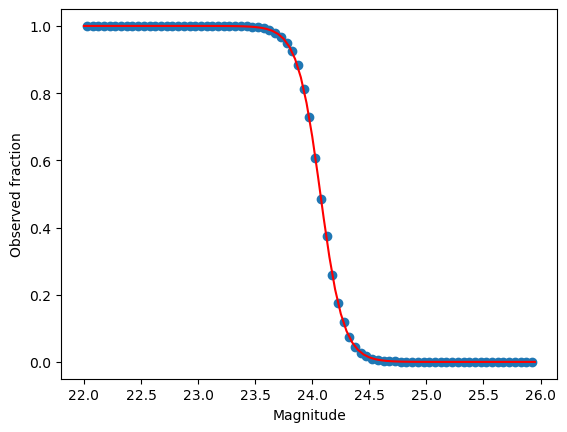

In [19]:
magcounts,magpins=np.histogram(dfobs['observedTrailedSourceMag'],bins=magbins)

reduced_dfobs=ff.PPFadingFunctionFilter(dfobs, 1.0, 0.1, rng)

redmagcounts,redmagbins=np.histogram(reduced_dfobs['observedTrailedSourceMag'],bins=magbins)

res=redmagcounts/magcounts

fiveSigma=dfobs.fiveSigmaDepthAtSource.values[0]

restheor=[]
i=0
while(i<len(magbins)):
    a=1./(1.+np.exp((magbins[i]-fiveSigma)/.1))
    restheor.append(a)
    i=i+1

plt.clf()
plt.scatter(magpins[:-1]+0.025,res)
plt.plot(magbins,restheor, 'r-')
plt.xlabel('Magnitude')
plt.ylabel('Observed fraction')
#plt.savefig('deteff_.jpg', bbox_inches='tight')
plt.show()

